#  Breast Cancer Diagnosis via Logistic Regression

In this demo, we will see how to visualize training data for classification, plot the logistic function and perform logistic regression.  As an example, we will use the widely-used breast cancer data set.  This data set is described here:

https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin

Each sample is a collection of features that were manually recorded by a physician upon inspecting a sample of cells from fine needle aspiration.  The goal is to detect if the cells are benign or malignant.

(source: Prof. Sundeep Rangan's ML course)

## Loading and Visualizing the Data

We first load the packages as usual.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model, preprocessing
import random
%matplotlib inline

In [2]:
random.seed(1)
np.random.seed(1)

Next, we load the data.  It is important to remove the missing values.

In [3]:
names = ['id','thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit','class']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/' +
                 'breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                names=names,na_values='?',header=None)
df = df.dropna()
df.head(6)

,id,thick,size_unif,shape_unif,marg,cell_size,bare,chrom,normal,mit,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2
5,1017122,8,10,10,8,7,10.0,9,7,1,4


After loading the data, we can create a scatter plot of the data labeling the class values with different colors.  We will pick two of the features.  

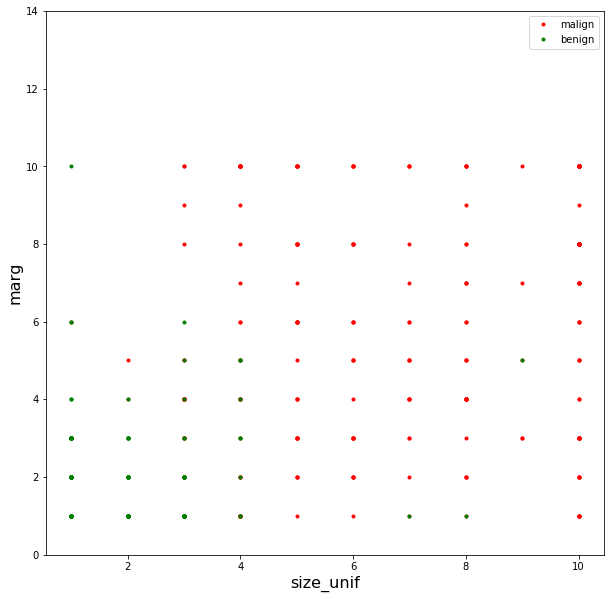

In [4]:
# Get the response.  Convert to a zero-one indicator 
yraw = np.array(df['class'])
BEN_VAL = 2   # value in the 'class' label for benign samples
MAL_VAL = 4   # value in the 'class' label for malignant samples
y = (yraw == MAL_VAL).astype(int)
Iben = (y==0)
Imal = (y==1)

# Get two predictors
xnames =['size_unif','marg'] 
X = np.array(df[xnames])

# Create the scatter plot
plt.figure(figsize=(10,10))
plt.plot(X[Imal,0],X[Imal,1],'r.')
plt.plot(X[Iben,0],X[Iben,1],'g.')
plt.xlabel(xnames[0], fontsize=16)
plt.ylabel(xnames[1], fontsize=16)
plt.ylim(0,14)
plt.legend(['malign','benign'],loc='upper right')

The above plot is not informative, since many of the points are on top of one another.  Thus, we cannot see the relative frequency of points.  

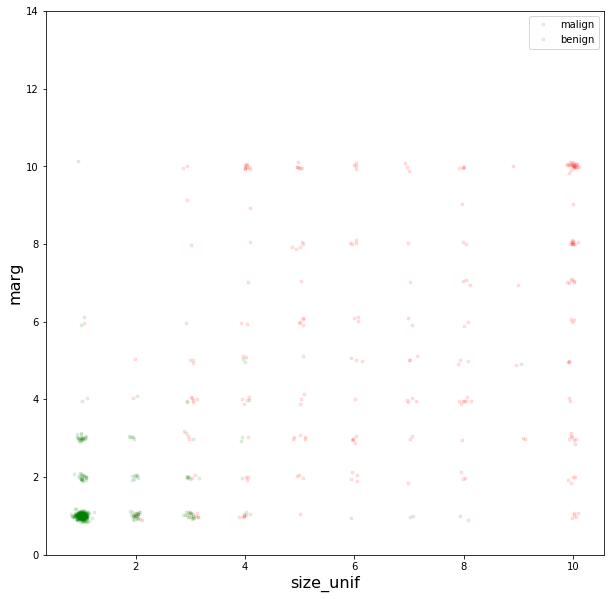

In [5]:
# Create the scatter plot with jitter
plt.figure(figsize=(10,10))
plt.plot(X[Imal,0]+np.random.randn(np.sum(Imal))*0.06, X[Imal,1]+np.random.randn(np.sum(Imal))*0.06,'r.', alpha=0.10)
plt.plot(X[Iben,0]+np.random.randn(np.sum(Iben))*0.06, X[Iben,1]+np.random.randn(np.sum(Iben))*0.06,'g.', alpha=0.10)
plt.xlabel(xnames[0], fontsize=16)
plt.ylabel(xnames[1], fontsize=16)
plt.ylim(0,14)
plt.legend(['malign','benign'],loc='upper right')

One way to improve the plot is to draw circles on each point whose size is proportional to the count of samples at that point.  We will re-use this code, so we define a function. 

<module 'matplotlib.pyplot' from '/home/serkan/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

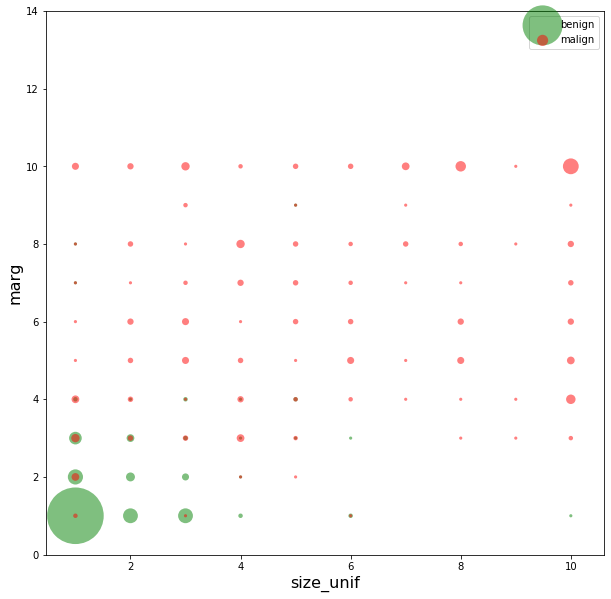

In [6]:
def plot_cnt(X,y):
    
    # Compute the bin edges for the 2d histogram
    x0val = np.array(list(set(X[:,0]))).astype(float)
    x1val = np.array(list(set(X[:,1]))).astype(float)
    x0, x1 = np.meshgrid(x0val,x1val)
    x0e= np.hstack((x0val,np.max(x0val)+1))
    x1e= np.hstack((x1val,np.max(x1val)+1))

    # Make a plot for each class
    yval = list(set(y))
    color = ['g','r']
    plt.figure(figsize=(10,10))
    for i in range(len(yval)):
        I = np.where(y==yval[i])[0]
        cnt, x0e, x1e = np.histogram2d(X[I,0],X[I,1],[x0e,x1e])
        x0, x1 = np.meshgrid(x0val,x1val)
        plt.scatter(x0.ravel(), x1.ravel(), s=10*cnt.ravel(),alpha=0.5,
                    c=color[i],edgecolors='none')
    plt.ylim([0,14])
    plt.legend(['benign','malign'], loc='upper right')
    plt.xlabel(xnames[0], fontsize=16)
    plt.ylabel(xnames[1], fontsize=16)
    return plt

plot_cnt(X,y)

## In-Class Exercise

Based on the above plot, what would be a good "classifer" using the two features.  That is, write a function that makes a prediction `yhat` of the class label `y`.  Code up your classifier function.  Measure the accuracy of the classifier on the data.  What percentage error does your classifier get?

In [7]:
# TODO

## Some Simple Classification ideas

Here are some ideas for classification that you may have already thought of.  We can see that the benign samples are located in the lower left.  So, one simple classification rule is to define the region with a line.  We plot the region for one possible line with the following code.

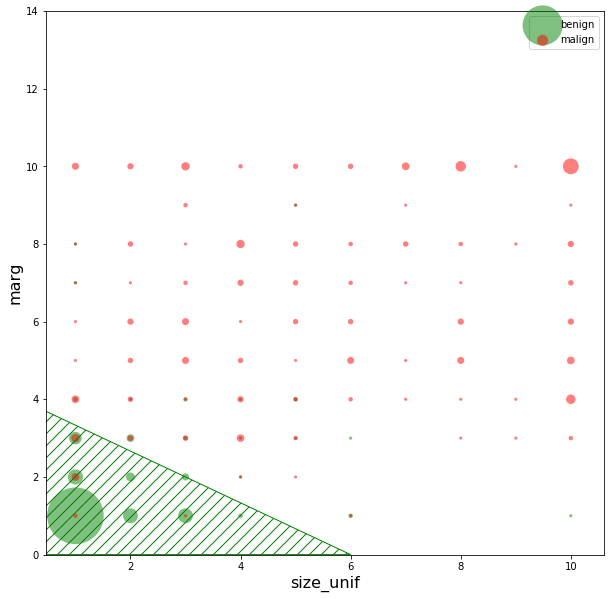

In [8]:
from matplotlib import patches
plt = plot_cnt(X,y)

ax = plt.gca() 
ax.add_patch(
    patches.Polygon([[0,0],[0,4],[6,0]],
        color='green',
        fill=False, hatch = '//'
    )
)

Here is an alternate classification rule based on two linear constraints.

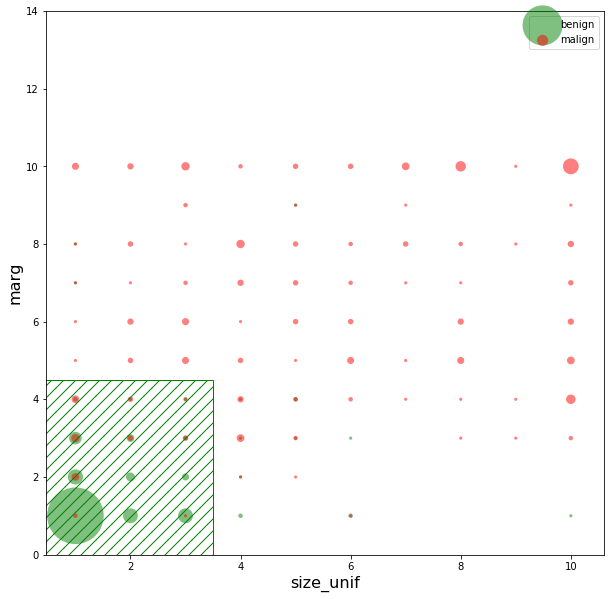

In [9]:
plt = plot_cnt(X,y)
ax = plt.gca()
ax.add_patch(
    patches.Rectangle(
        (0, 0),   # (x,y)
        width=3.5, height=4.5,  color='green',
        fill=False, hatch = '//'
    )
)

## Let us try to find the best linear classifier by using linear regression!

In [10]:
xnames =['size_unif','marg'] 
X = np.array(df[xnames])
y1=y-0.5 
from sklearn import datasets, linear_model
regr = linear_model.LinearRegression()
regr.fit(X,y1)
print('regr.intercept=',regr.intercept_)
print('regr.coef=',regr.coef_)

regr.intercept= -0.5842006662006147
regr.coef= [0.10007944 0.04197521]


We can visualize this linear regression function as a separating line by setting y1=0, and find the relation between the two features by setting
w0+w1 x1 + w2 x2 = 0 -> x2=(-w0 - w1 x1)/w2
We can plot this line together with the previous scatter plot

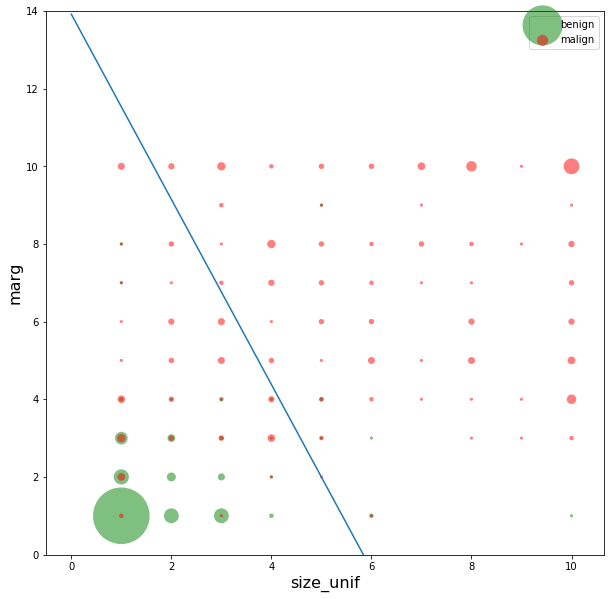

In [11]:

w0=regr.intercept_
w1=regr.coef_[0]
w2=regr.coef_[1]
plt = plot_cnt(X,y)
x1=np.zeros([11,1])
x2=np.zeros([11,1])
for i in range(11):
    x1[i]=i;
    x2[i]=(- w0-w1*i)/w2
    
plt.plot(x1, x2)

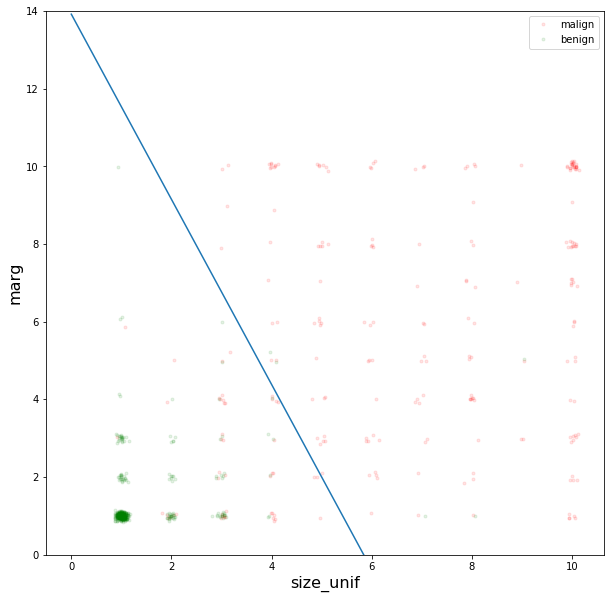

In [12]:
# Create the scatter plot
plt.figure(figsize=(10,10))
plt.plot(X[Imal,0]+np.random.randn(np.sum(Imal))*0.06, X[Imal,1]+np.random.randn(np.sum(Imal))*0.06,'r.', alpha=0.10)
plt.plot(X[Iben,0]+np.random.randn(np.sum(Iben))*0.06, X[Iben,1]+np.random.randn(np.sum(Iben))*0.06,'g.', alpha=0.10)
plt.xlabel(xnames[0], fontsize=16)
plt.ylabel(xnames[1], fontsize=16)
plt.ylim(0,14)
plt.legend(['malign','benign'],loc='upper right')
x1=np.zeros([11,1])
x2=np.zeros([11,1])
for i in range(11):
    x1[i]=i;
    x2[i]=(- w0-w1*i)/w2
    
plt.plot(x1, x2)


In [13]:
yhat=regr.predict(X)
yhati= (yhat >=0).astype(int)
acc = np.mean(yhati == y)
print("Accuracy on training data using two features = %f" % acc)

Accuracy on training data using two features = 0.922401


In [14]:
xnames = ['thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit']
X = np.array(df[xnames])

Xs = preprocessing.scale(X)
regr.fit(Xs,y1)
yhat=regr.predict(Xs)
yhati= (yhat >=0).astype(int)
acc = np.mean(yhati == y)
print("Accuracy on training data using 10 features = %f" % acc)

Accuracy on training data using 10 features = 0.960469


In [15]:
data = {'feature': xnames, 'slope': np.squeeze(regr.coef_)}
dfslope = pd.DataFrame(data=data)
dfslope

,feature,slope
0,thick,0.089390
1,size_unif,0.066909
2,shape_unif,0.046706
3,marg,0.023596
4,cell_size,0.022381
5,bare,0.165260
6,chrom,0.046940
7,normal,0.056522
8,mit,0.001695


## Logistic Functions


This demo illustrate an important classifier known as *logistic regression*.  In logistic regression, we do not just output an estimate of the class label, `yhat`.  Instead, we ouput a *probability*, an estimate of how likely the sample is one class or the other.  That is our output is a number from 0 to 1 representing the likelihood:
$$
    P(y = 1|x)
$$
which is our estimate of the probability that the sample is one class (in this case, a malignant sample) based on the features `x`.  This is sometimes called a *soft classifier*.  

In logistic regression, we assume that likelihood is of the form
$$
    P(y=1|x) = f(z),  \quad z = w_0 + w_1x_1 + \cdots + w_kx_k,  
$$
where $w_0,\ldots,w_k$ are the classifier weights and $f(z)$ is the so-called *logistic* function:
$$
    f(z) = \frac{1}{1+e^{-z}}.
$$

To understand the logistic function, suppose $x$ is a scalar and samples $y$ are drawn with $P(y=1|x) = f(w_1x)$ for some scaling constant $w_1$.  We plot these samples for different $w_1$.

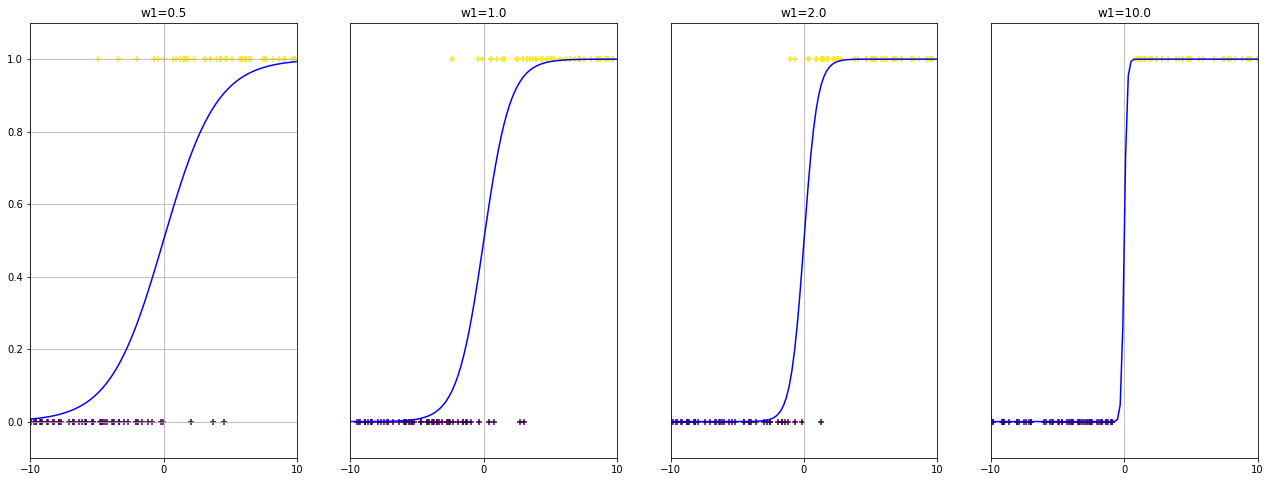

In [16]:
nx = 100
xm = 10
w1s = np.array([0.5,1,2,10])
nplot = w1s.size
iplot = 0
plt.figure(figsize=(22,8))
for w1 in w1s:
    iplot += 1
    x  = np.random.uniform(-xm,xm,nx)
    plt.subplot(1,nplot,iplot)
    py = 1/(1+np.exp(-w1*x))
    yp = np.array(np.random.rand(nx) < py)
    xp = np.linspace(-xm,xm,100)
    pyp = 1/(1+np.exp(-w1*xp))

    plt.scatter(x,yp,c=yp,edgecolors='none',marker='+')
    plt.plot(xp,pyp,'b-')
    plt.axis([-xm,xm,-0.1,1.1])
    plt.grid()
    if (iplot > 1):
        plt.yticks([])
    plt.xticks([-10,0,10])
    plt.title('w1={0:.1f}'.format(w1))


In [17]:
sigmoid = lambda x: 1/(1+np.exp(-x))

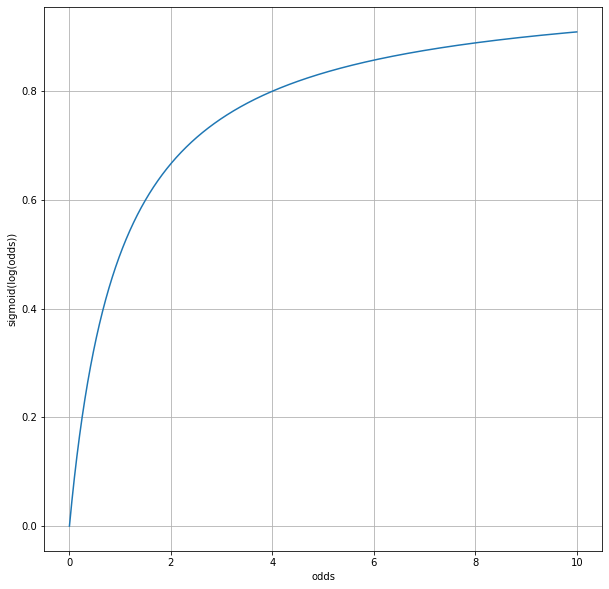

In [18]:
plt.figure(figsize=(10,10))
x = np.linspace(1e-5,10,5000)
plt.plot(x,sigmoid(np.log(x)))
plt.xlabel('odds')
plt.ylabel('sigmoid(log(odds))')
plt.grid()

We see that $f(w_1x)$ represents the probability that $y=1$.  The function $f(w_1x) > 0.5$ for $x>0$ meaning the samples are more likely to be $y=1$.  Similarly, for $x<0$, the samples are more likely to $y=0$.  The scaling $w_1$ determines how fast that transition is.

## Fitting the Logistic Model

In a logistic model, we must fit the weights $w_0,w_1,\ldots,w_k$ in the model 
$$
    P(y=1|x) = f(z),  \quad z = w_0 + w_1x_1 + \cdots + w_kx_k,  
$$
The `sklearn` module has very good routines for fitting this model.  First we get the training data and samples.  We will standardize the `X` values to make more sense of the slope values.

In [19]:
xnames = ['thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit']
X = np.array(df[xnames])
Xs = preprocessing.scale(X)

Next, we create a logistic regression object.  The parameter `C` states the level of regularization and will be discussed in class.

In [20]:
logreg = linear_model.LogisticRegression(C=1e5)

Then, we fit the model.

In [21]:
logreg.fit(Xs, y)

/home/serkan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

We can next plot the accuracy on the training data.  We see we get an accuracy better than simple linear classifier. 

In [22]:
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y)
print("Accuracy on training data = %f" % acc)

Accuracy on training data = 0.969253


It is also useful to print the weights for each feature.  We can use the `pandas` package to make a table. 

In [23]:
W=logreg.coef_
data = {'feature': xnames, 'slope': np.squeeze(W)}
dfslope = pd.DataFrame(data=data)
dfslope

,feature,slope
0,thick,1.508834
1,size_unif,-0.015979
2,shape_unif,0.957072
3,marg,0.947234
4,cell_size,0.214964
5,bare,1.395001
6,chrom,1.095654
7,normal,0.650696
8,mit,0.925912


## Cross-Validation

The above code measured the accuracy on the training data.  However, we should measure the accuracy on test data.  We perform 4-fold cross-validation and print average precision, recall, f1-score and accuracy.


In [24]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
nfold = 10
kf = KFold(n_splits=nfold)
prec = []
rec = []
f1 = []
acc = []
for train, test in kf.split(Xs):            
    # Get training and test data
    Xtr = Xs[train,:]
    ytr = y[train]
    Xts = Xs[test,:]
    yts = y[test]
    
    # Fit a model
    logreg.fit(Xtr, ytr)
    yhat = logreg.predict(Xts)
    
    # Measure performance
    preci,reci,f1i,_= precision_recall_fscore_support(yts,yhat,average='binary') 
    prec.append(preci)
    rec.append(reci)
    f1.append(f1i)
    acci = np.mean(yhat == yts)
    acc.append(acci)

# Take average values of the metrics
precm = np.mean(prec)
recm = np.mean(rec)
f1m = np.mean(f1)
accm= np.mean(acc)

# Compute the standard errors
prec_se = np.std(prec)/np.sqrt(nfold-1)
rec_se = np.std(rec)/np.sqrt(nfold-1)
f1_se = np.std(f1)/np.sqrt(nfold-1)
acc_se = np.std(acc)/np.sqrt(nfold-1)

print('Precision = {0:.4f}, SE={1:.4f}'.format(precm,prec_se))
print('Recall =    {0:.4f}, SE={1:.4f}'.format(recm, rec_se))
print('f1 =        {0:.4f}, SE={1:.4f}'.format(f1m, f1_se))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm, acc_se))

Precision = 0.9610, SE=0.0118
Recall =    0.9615, SE=0.0144
f1 =        0.9608, SE=0.0112
Accuracy =  0.9679, SE=0.0110


/home/serkan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serkan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serkan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serkan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serkan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

## Precision, Recall and F1 Score
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png">
$\text{Accuracy}=\frac{tp+tn}{tp+tn+fp+fn} $

$\text{Precision}=\frac{tp}{tp+fp}$

$\text{Recall}=\frac{tp}{tp+fn}$

$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$

([wiki page](https://en.wikipedia.org/wiki/Precision_and_recall))

## ROC curve

As discussed above, the logistic classifier outputs a *soft* classification $P(y=1|x)$.  One simple idea is to select the class label $\hat{y}=1$ whenever $P(y=1|x) > 0.5$.  However, one can also set $\hat{y}=1$ whenever $P(y=1|x) > t$ for some threshold $t$.  Using higher thresholds values selects $\hat{y}=0$ more often which results in fewer *false alarms*, but also many *missed detections* (reduces sensitivity).  Similarly, lower thresholds values selects $\hat{y}=1$ more often which results in fewer *missed detections* (increases *sensitivity*) but also more *false alarms*.  The ROC curve displays this  tradeoff by graphing the *true positive rate* vs. *false positive rate* obtained with different $t$.  

The ROC curve can be plotted in the `sklearn` package with the following code.

(0, 0.1)

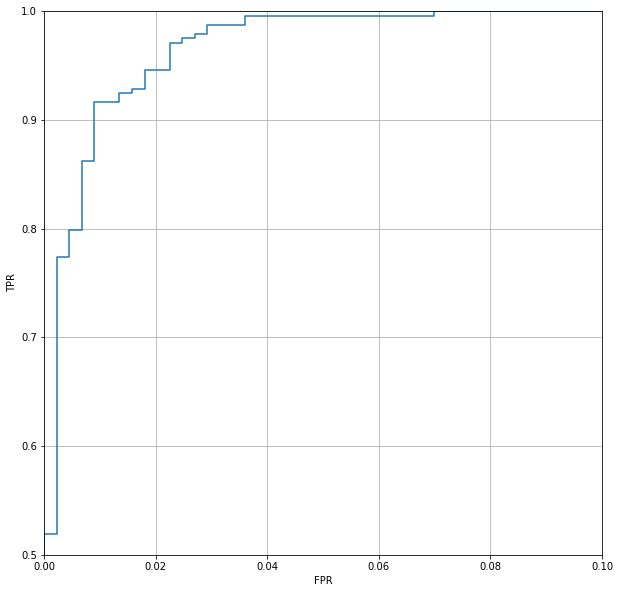

In [25]:
from sklearn import metrics
yprob = logreg.predict_proba(Xs)
fpr, tpr, thresholds = metrics.roc_curve(y,yprob[:,1])

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr)
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.5,1])
plt.xlim([0,0.1])

Now let us see what are the relation between the threshold and the TPR and FPR.

Text(0.5, 0, 'Threshold')

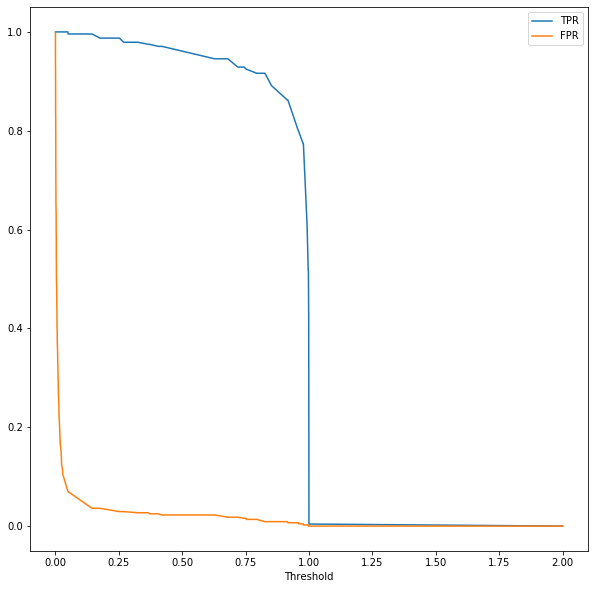

In [26]:
plt.figure(figsize=(10,10))
plt.plot(thresholds,tpr, thresholds,fpr)
plt.legend(['TPR','FPR'])
plt.xlabel('Threshold')

The goodness of a classification method is often measured by the area under the curve (AUC), which is independent of the threshold. A method with a higher AUC means that under the same FPR, it has higher PPR. Note that in practice, you should evalute UAC in different cross validation folds and then evaluate the mean AUC.

In [27]:
auc=metrics.roc_auc_score(y,yprob[:,1])
print("AUC=%f" % auc)

AUC=0.996297


## LASSO regularization
As with linear regression, we can use LASSO regression to force the weighting coefficients to have small L1 norm, which will have the effect to reducing the number of non-zero coefficients. This is particularly important when there are many features and not enough training samples. the LogisticRegression method of sklearn allows one to add a regularization term (penalty), which could be either L2 or L1 norm. By setting the penalty to l1, you are effectively using LASSO regularization. The parameter C is inversely related to the regularization level. You can observe that as you reduces C, you will get fewer and fewer non-zero coefficients. To determine the appropriate C, we will use cross validation. Note that with the current example, we have sufficient number of samples for the number of features, so we do not expect to see the benefit of LASSO regression. First let us determine the C value leading to the minimum error rate (1-accuracy). We also count the number of non-zero coefficients.

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


/home/serkan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serkan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serkan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serkan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serkan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

The minimum test error rate =   3.0754e-02, SE=  6.3435e-03
The C value corresponding to minimum error =   1.8330e-01


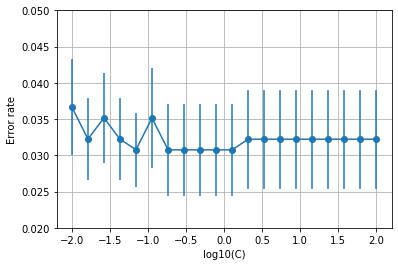

In [28]:
npen = 20
C_test = np.logspace(-2,2,npen)

# Create the cross-validation object and error rate matrix
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
err_rate = np.zeros((npen,nfold))
num_nonzerocoef = np.zeros((npen,nfold))
# Create the logistic regression object
logreg = linear_model.LogisticRegression(penalty='l1',warm_start=True)

# Loop over the folds in the cross-validation
for ifold, Ind in enumerate(kf.split(Xs)):        
            
    # Get training and test data
    Itr, Its = Ind
    Xtr = Xs[Itr,:]
    ytr = y[Itr]
    Xts = Xs[Its,:]
    yts = y[Its]
    
    # Loop over penalty levels
    for ipen, c in enumerate(C_test):
        
        # Set the penalty level        
        logreg.C= c
    
        # Fit a model on the training data
        logreg.fit(Xtr, ytr)
    
        # Predict the labels on the test set.
        yhat = logreg.predict(Xts)
        
        # Measure the accuracy
        err_rate[ipen,ifold] = np.mean(yhat != yts)
        num_nonzerocoef[ipen,ifold]=np.sum(abs(logreg.coef_)>0.001)
    print("Fold %d" % ifold)
    
err_mean = np.mean(err_rate, axis=1)
num_nonzerocoef_mean = np.mean(num_nonzerocoef, axis=1)
err_se = np.std(err_rate,axis=1)/np.sqrt(nfold-1)
plt.errorbar(np.log10(C_test), err_mean, marker='o',yerr=err_se)
plt.ylim([0.02,0.05])
plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('Error rate')

imin = np.argmin(err_mean)

print("The minimum test error rate = %12.4e, SE=%12.4e" % (err_mean[imin], err_se[imin]))
print("The C value corresponding to minimum error = %12.4e" % (C_test[imin]))




## K-Fold Cross Validation
<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png">

(source: [scikit learn docs](https://scikit-learn.org/stable/modules/cross_validation.html))

Now let us find the optimal C using one standard error rule. Note that because C is inversely related to the regularization strength, we want to find the minimal C that satisfies the error criterion. We will also find the corresponding test accuracy with this optimal C, and compare with the test accuracy without regularization.

In [29]:
err_tgt = err_mean[imin] + err_se[imin]
iopt = np.where(err_mean < err_tgt)[0][0]
C_opt = C_test[iopt]

print("Optimal C=%12.4e" % C_opt)
print("The test error rate = %12.4e, SE=%12.4e" % (err_mean[iopt], err_se[iopt]))

print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(1-err_mean[iopt], err_se[iopt]))

Optimal C=  1.0000e-02
The test error rate =   3.6658e-02, SE=  6.6755e-03
Accuracy =  0.9633, SE=0.0067


Now plot the nubmer of non-zero coefficients for the first class for different C values. Also determine and print the number of non-zero coefficients corresponding to C_opt.

The number of non-zero coefficients for the optimal C = 4.500000


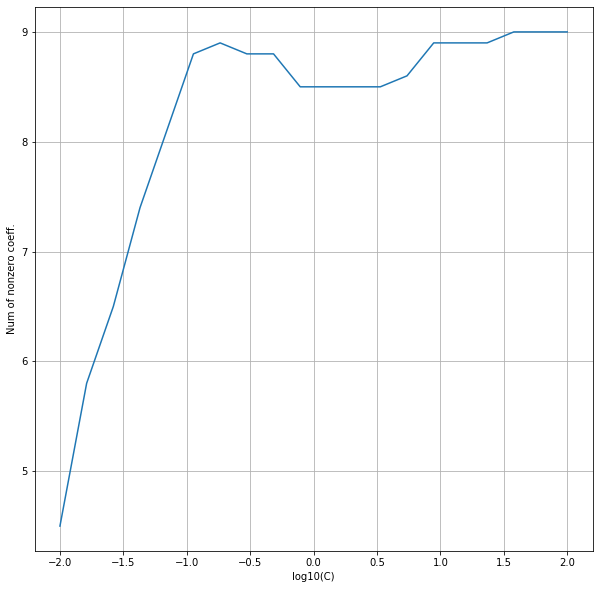

In [30]:
num_nonzerocoef_mean = np.mean(num_nonzerocoef, axis=1)
plt.figure(figsize=(10,10))
plt.plot(np.log10(C_test),num_nonzerocoef_mean)

plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('Num of nonzero coeff.')

print("The number of non-zero coefficients for the optimal C = %f" % num_nonzerocoef_mean[iopt])

For the optimal `C`, fit the model on the entire training data with l1 regularization. Find the resulting weight matrix, `W_l1`.  Plot the first row of this weight matrix and compare it to the first row of the weight matrix without the regularization.  You should see that, with l1-regularization, the weight matrix is much more sparse. Please also compare the accuracy for the training data using optimal `C` with the previous results not using LASSO regularization.

Accuracy on the training data is 0.966325


/home/serkan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/serkan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/home/serkan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyw

Text(0.5, 1.0, 'l1-regularization')

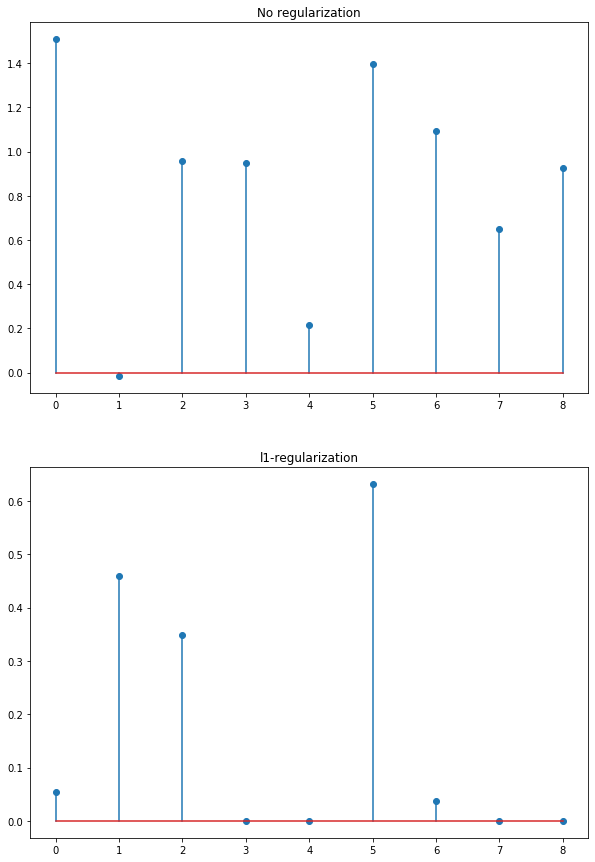

In [31]:
logreg = linear_model.LogisticRegression(C=C_opt,penalty='l1')
logreg.C= C_opt
logreg.fit(Xs,y)
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y)
print('Accuracy on the training data is {0:f}'.format(acc))
W_l1 = logreg.coef_

plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
plt.stem(W[0,:])
plt.title('No regularization')
plt.subplot(2,1,2)
plt.stem(W_l1[0,:])
plt.title('l1-regularization')


The accuracy for the training data without regularization was 0.9692. So with regularization, we were able to improve the accuracy slightly. Note that actual results vary each time you run, because the optimal C depends on the cross validation split, which is random. When the nubmer of samples is small relative to the number of features, more and consistant gain is expected.